<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install accelerate -U
!pip install transformers
!pip install evaluate
!pip install datasets
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.11.0
    Uninstalling accelerate-1.11.0:
      Successfully uninstalled accelerate-1.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
from typing import Union, Dict
import pandas as pd
from datasets import Dataset
import transformers
import evaluate

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
def create_label_mapping(dataset):
    unique_topics = sorted(set(dataset["topic"]))
    topic_to_id = {topic: idx for idx, topic in enumerate(unique_topics)}
    id_to_topic = {idx: topic for topic, idx in topic_to_id.items()}
    return topic_to_id, id_to_topic, len(unique_topics)

In [6]:
df = pd.read_excel('/content/drive/MyDrive/ml/DLS(LLM)/дз/data_problems_translated.xlsx')
dataset = Dataset.from_pandas(df)

topic_to_id, id_to_topic, num_classes = create_label_mapping(dataset)

print(f"Количество классов: {num_classes}")
for topic, idx in topic_to_id.items():
    print(f"  {idx}: {topic}")

Количество классов: 7
  0: combinatorics
  1: dirichlet
  2: geometry
  3: graphs
  4: invariant
  5: number_theory
  6: polynoms


In [7]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [25]:
def preprocess_function(examples, tokenizer, topic_to_id):
    texts = [str(t) if t is not None else "" for t in examples["problem_text"]]

    labels = [topic_to_id.get(str(t), 0) for t in examples["topic"]]

    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )

    tokenized["labels"] = labels
    return tokenized

In [42]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int = 7, dropout_rate=0):
        super().__init__()
        if isinstance(base_transformer_model, str):
            self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model

        # create additional layers for classfication
        self.hidden_size = self.backbone.config.hidden_size

        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.hidden_size, num_classes)

        self.loss_fct = nn.CrossEntropyLoss()
    def forward(self, input_ids, attention_mask=None, labels=None):
        if attention_mask is None:
            attention_mask = (input_ids != 0).int()
        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=False,
            return_dict=True
        )

        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            pooled_output = outputs.pooler_output
        else:
            pooled_output = outputs.last_hidden_state[:, 0, :]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        return {'loss': loss, 'logits': logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [10]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [47]:
import copy
from transformers import TrainingArguments, Trainer
from transformers import DefaultDataCollator
from sklearn.metrics import accuracy_score
# Метрика точности
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return {"accuracy": accuracy_score(labels, predictions)}

def train_transformer(
    transformer_model,
    tokenized_dataset,
    freeze_backbone=True,
    tokenizer=None,
    output_dir="/content/drive/MyDrive/ml/DLS(LLM)/дз/models",
    num_epochs=5,
    batch_size=8,
    lr=2e-5,
    wd=0.01
):
    model = copy.deepcopy(transformer_model)

    # Заморозка backbone, если нужно
    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    # Data collator для batch
    data_collator = DefaultDataCollator(return_tensors="pt")

    # Параметры тренировки
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        weight_decay=wd,
        save_total_limit=2,
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        dataloader_pin_memory=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model(f"{output_dir}/best_model")
    return model


### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [26]:
tokenizer = transformers.AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
tokenized_dataset = dataset.map(
    lambda examples: preprocess_function(examples, tokenizer, topic_to_id),
    batched=True,
    remove_columns=dataset["train"].column_names
)

Map:   0%|          | 0/4218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055 [00:00<?, ? examples/s]

In [24]:
df['token_length'] = df['problem_text'].apply(lambda x: len(tokenizer(str(x))['input_ids']) if x is not None else 0)
print(df['token_length'].describe())

count    5273.000000
mean       63.108288
std        56.831018
min         3.000000
25%        32.000000
50%        50.000000
75%        76.000000
max       666.000000
Name: token_length, dtype: float64


In [31]:
rubert_tiny_transformer_model_1 = TransformerClassificationModel(
    base_transformer_model="cointegrated/rubert-tiny2",
    num_classes=num_classes
)
# Обучаем с замороженным backbone
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model_1,
    tokenized_dataset,
    freeze_backbone=True,
    tokenizer=tokenizer,
    output_dir="/content/drive/MyDrive/ml/DLS(LLM)/дз/freezed_backbone"
)

/tmp/ipython-input-3837983032.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.937200,1.895153,0.452133
2,1.876300,1.841062,0.475829
3,1.833700,1.805781,0.473934
4,1.807800,1.786021,0.475829
5,1.794300,1.779684,0.475829


In [35]:
rubert_tiny_transformer_model_2 = TransformerClassificationModel(
    base_transformer_model="cointegrated/rubert-tiny2",
    num_classes=num_classes
)

# Обучаем с размороженным backbone
rubert_tiny_full_finetuned = train_transformer(
    rubert_tiny_transformer_model_2,
    tokenized_dataset,
    freeze_backbone=False,
    tokenizer=tokenizer,
    output_dir="/content/drive/MyDrive/ml/DLS(LLM)/дз/full_finetune",
    num_epochs=4,
    batch_size=8,
)

/tmp/ipython-input-410842718.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.401100,1.150986,0.592417
2,1.130900,1.061895,0.618957
3,1.037800,1.023427,0.625592
4,1.003300,1.019554,0.623697


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [36]:
mathbert_tokenizer = transformers.AutoTokenizer.from_pretrained("tbs17/MathBert")
mathbert_tokenized_dataset = dataset.map(
    lambda examples: preprocess_function(examples, mathbert_tokenizer, topic_to_id),
    batched=True,
    remove_columns=dataset["train"].column_names
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055 [00:00<?, ? examples/s]

In [37]:
mathbert_model = TransformerClassificationModel(
    base_transformer_model="tbs17/MathBert",
    num_classes=num_classes
)

mathbert_frozen = train_transformer(
    mathbert_model,
    mathbert_tokenized_dataset,
    freeze_backbone=True,
    tokenizer=mathbert_tokenizer,
    output_dir="/content/drive/MyDrive/ml/DLS(LLM)/дз/mathbert_frozen",
    num_epochs=4,
    batch_size=8
)

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/tmp/ipython-input-410842718.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.675200,1.551998,0.476777
2,1.598900,1.531334,0.476777
3,1.587000,1.521434,0.476777
4,1.576100,1.517924,0.476777


Чтобы бороться с переобучением добавим dropout, до этого мы тренировали без него модель mathbert_model_2, там переобучение сильнее выражено (результат модели, к сожалению, не сохранился).

In [46]:
mathbert_model_2 = TransformerClassificationModel(
    base_transformer_model="tbs17/MathBert",
    num_classes=num_classes,
    dropout_rate=0.3
)

mathbert_full = train_transformer(
    mathbert_model_2,
    mathbert_tokenized_dataset,
    freeze_backbone=False,
    tokenizer=mathbert_tokenizer,
    output_dir="/content/drive/MyDrive/ml/DLS(LLM)/дз/mathbert_full",
    num_epochs=3,
    batch_size=8
)

/tmp/ipython-input-651750381.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.170000,0.998276,0.632227
2,0.853700,0.948990,0.633175
3,0.671200,1.009018,0.614218


Можно сделать сильнее также регуляризацию.

In [49]:
mathbert_model_3 = TransformerClassificationModel(
    base_transformer_model="tbs17/MathBert",
    num_classes=num_classes,
    dropout_rate=0.3
)

mathbert_full = train_transformer(
    mathbert_model_3,
    mathbert_tokenized_dataset,
    freeze_backbone=False,
    tokenizer=mathbert_tokenizer,
    output_dir="/content/drive/MyDrive/ml/DLS(LLM)/дз/mathbert_full",
    num_epochs=3,
    batch_size=8,
    wd=0.05
)

/tmp/ipython-input-95270618.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.172900,0.984815,0.636967
2,0.855000,0.953724,0.641706
3,0.665800,1.015516,0.619905


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [61]:
import matplotlib.pyplot as plt
from typing import List

def draw_first_layer_attention_maps(attention_head_ids: List[int], text: str, model: TransformerClassificationModel, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")

    model.backbone.eval()
    with torch.no_grad():
        outputs = model.backbone(**inputs, output_attentions=True, return_dict=True)

    attentions = outputs.attentions[0]  # первый слой
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    for head_id in attention_head_ids:
        if head_id >= attentions.shape[1]:
            print(f"Head id {head_id} превышает количество голов {attentions.shape[1]}")
            continue

        attn_matrix = attentions[0, head_id].cpu().numpy()  # [seq_len, seq_len]

        plt.figure(figsize=(10, 8))
        plt.imshow(attn_matrix, cmap='viridis')
        plt.xticks(range(len(tokens)), tokens, rotation=90)
        plt.yticks(range(len(tokens)), tokens)
        plt.colorbar()
        plt.title(f"Attention Head {head_id} (Layer 1)")
        plt.show()


### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [67]:
example_texts = df['problem_text'].iloc[:3].tolist()

print("ВЫБРАННЫЕ ТЕКСТЫ ДЛЯ АНАЛИЗА:")
for i, text in enumerate(example_texts):
    print(f"{i+1}. {text}")

ВЫБРАННЫЕ ТЕКСТЫ ДЛЯ АНАЛИЗА:
1. To prove that the sum of the numbers of the exact square cannot be equal to 5.
2. ( b) Will the statement of the previous challenge remain true if Petia and Wasa originally planned four natural numbers?
3. The quadratic three-member graph with the coefficients has two points with the coordinates. Show that if the distance between them is the whole number, then the fraction is parallel to the abscisse axis.


In [74]:
from typing import List, Dict, Tuple
def analyze_models_attention(
    models_to_analyze: Dict[str, Tuple[TransformerClassificationModel, transformers.PreTrainedTokenizer]],
    example_texts: List[str],
    heads_to_visualize: int = 3,
    id_to_topic: Dict[int, str] = None
    ):
    """
    Проводит инференс и визуализирует карты внимания для списка моделей.
    """
    for model_name, (model, model_tokenizer) in models_to_analyze.items():
        print(f"\n МОДЕЛЬ: {model_name}")

        for i, text in enumerate(example_texts):
            print(f"\n Текст {i+1}: {text[:80]}...")

            # Определяем количество голов в модели
            num_heads = model.backbone.config.num_attention_heads
            actual_heads = list(range(min(heads_to_visualize, num_heads)))
            print(f"Количество голов внимания: {num_heads}, визуализируем головы: {actual_heads}")

            # Отрисовываем карты внимания
            draw_first_layer_attention_maps(
                attention_head_ids=actual_heads,
                text=text,
                model=model,
                tokenizer=model_tokenizer
            )

            # Проводим инференс
            inputs = model_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
            model.eval()
            with torch.no_grad():
                outputs = model(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask']
                )
            logits = outputs['logits']
            predicted_class = logits.argmax(-1).item()
            p = torch.softmax(logits, dim=-1).max().item()

            if id_to_topic is not None:
                class_name = id_to_topic[predicted_class]
            else:
                class_name = str(predicted_class)

            print(f"Предсказание: класс {predicted_class} ({class_name}), вероятность: {p:.3f}")

    # Детальный анализ конкретных голов для сравнения моделей
    print("\n СРАВНЕНИЕ ОДИНАКОВЫХ HEAD'ОВ В РАЗНЫХ МОДЕЛЯХ")

    detailed_text = example_texts[0]
    print(f"\n Текст для сравнения: {detailed_text}")

    for head_id in range(heads_to_visualize):
        print(f"\n HEAD {head_id}:")

        for model_name, (model, model_tokenizer) in models_to_analyze.items():
            print(f"\n{model_name}:")
            num_heads = model.backbone.config.num_attention_heads
            if head_id >= num_heads:
                print(f"Head {head_id} не существует (макс: {num_heads-1})")
                continue

            draw_first_layer_attention_maps(
                attention_head_ids=[head_id],
                text=detailed_text,
                model=model,
                tokenizer=model_tokenizer
            )

In [69]:
models_to_analyze_before = {
    "RuBert-Tiny (необученный)": (rubert_tiny_transformer_model_1, tokenizer),
    "MathBert (необученный)": (mathbert_model, mathbert_tokenizer)
}


 МОДЕЛЬ: RuBert-Tiny (необученный)

 Текст 1: To prove that the sum of the numbers of the exact square cannot be equal to 5....
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


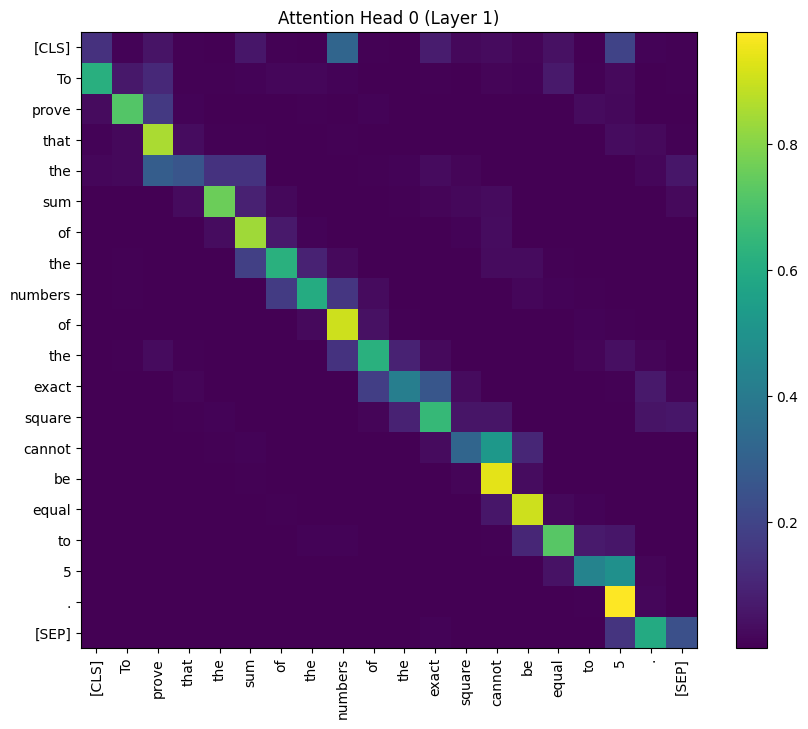

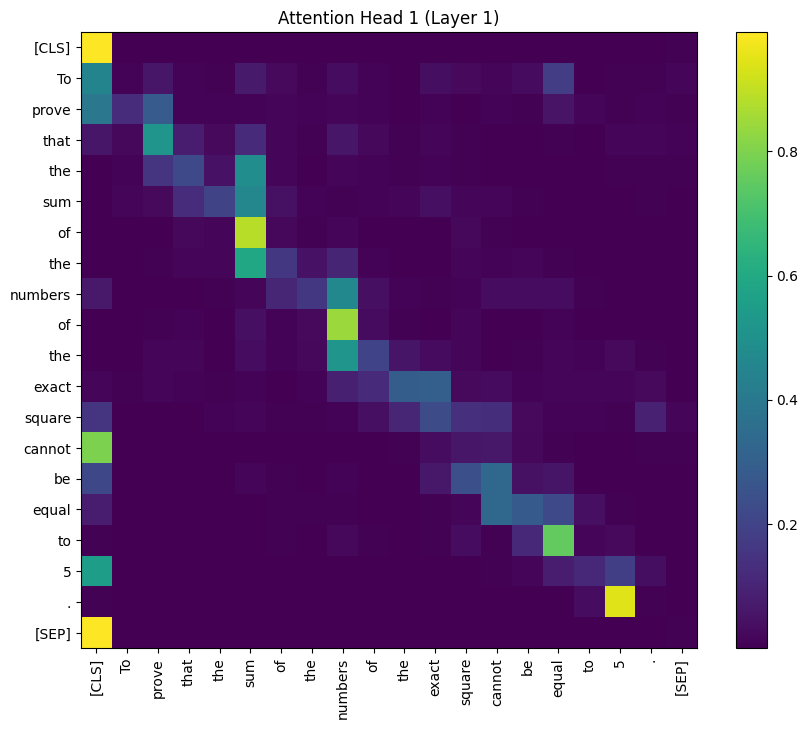

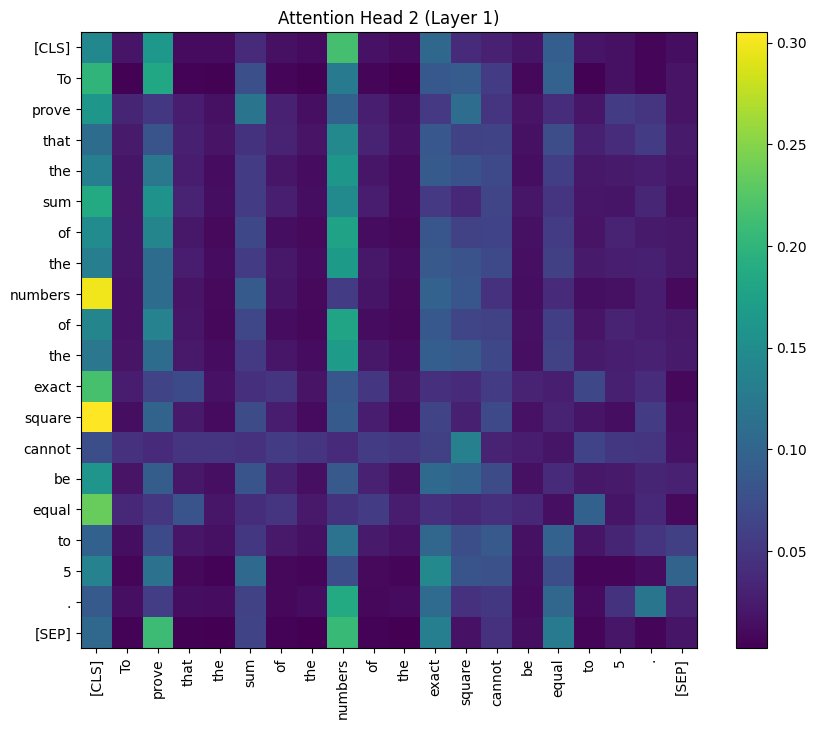

Предсказание: класс 3 (graphs), вероятность: 0.157

 Текст 2: ( b) Will the statement of the previous challenge remain true if Petia and Wasa ...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


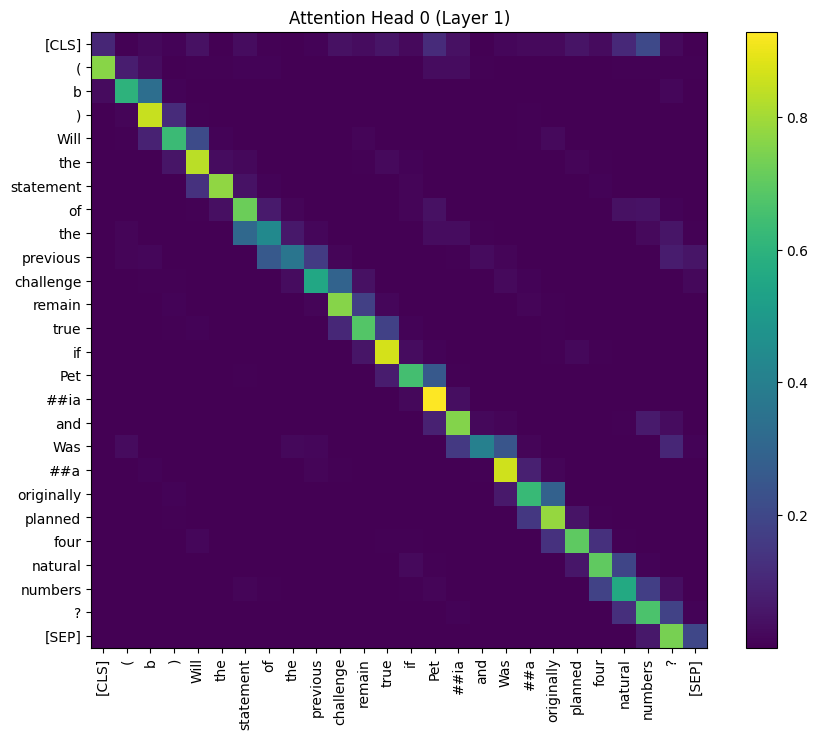

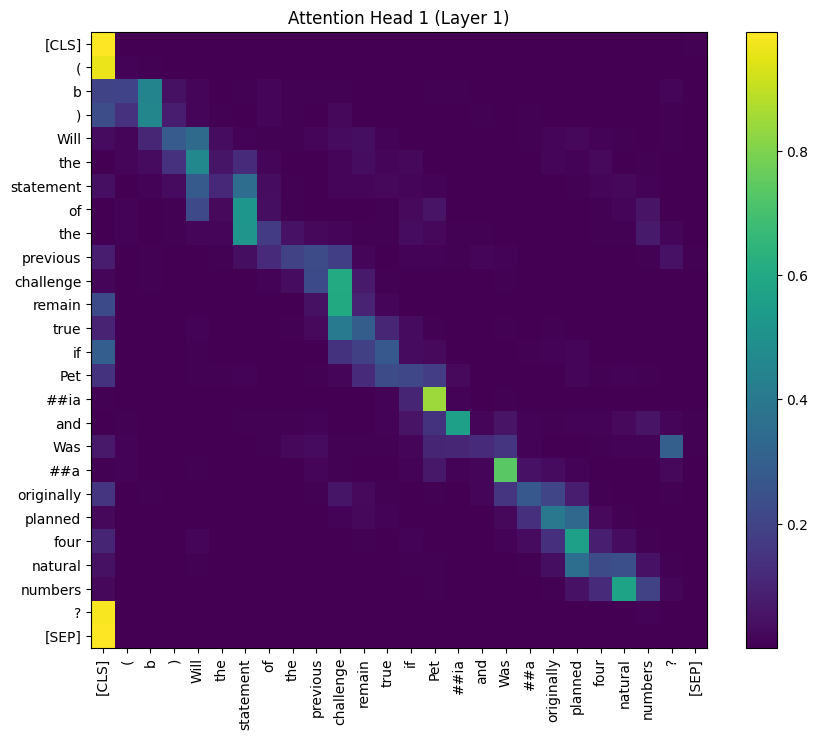

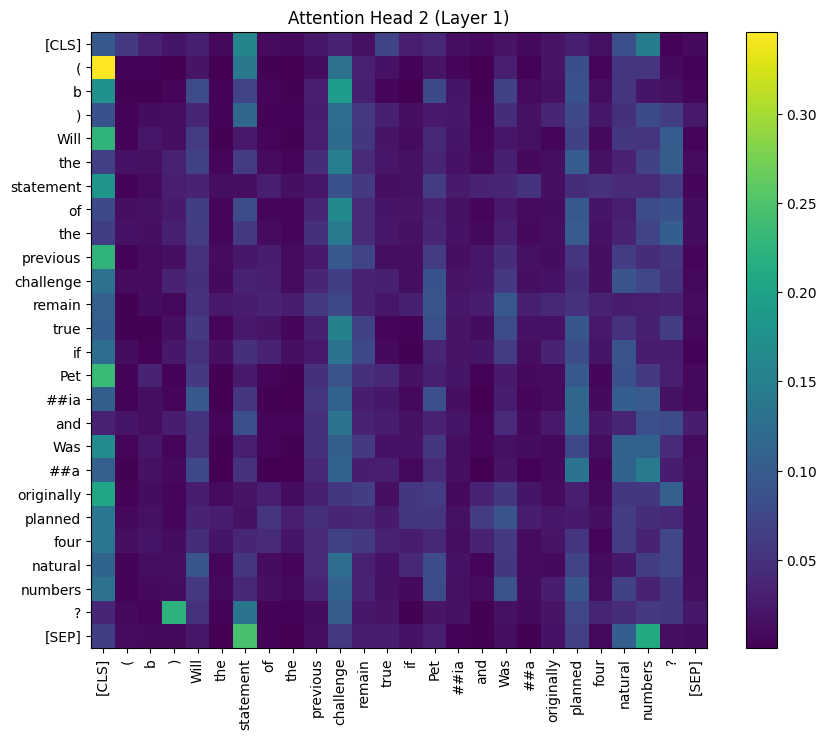

Предсказание: класс 3 (graphs), вероятность: 0.165

 Текст 3: The quadratic three-member graph with the coefficients has two points with the c...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


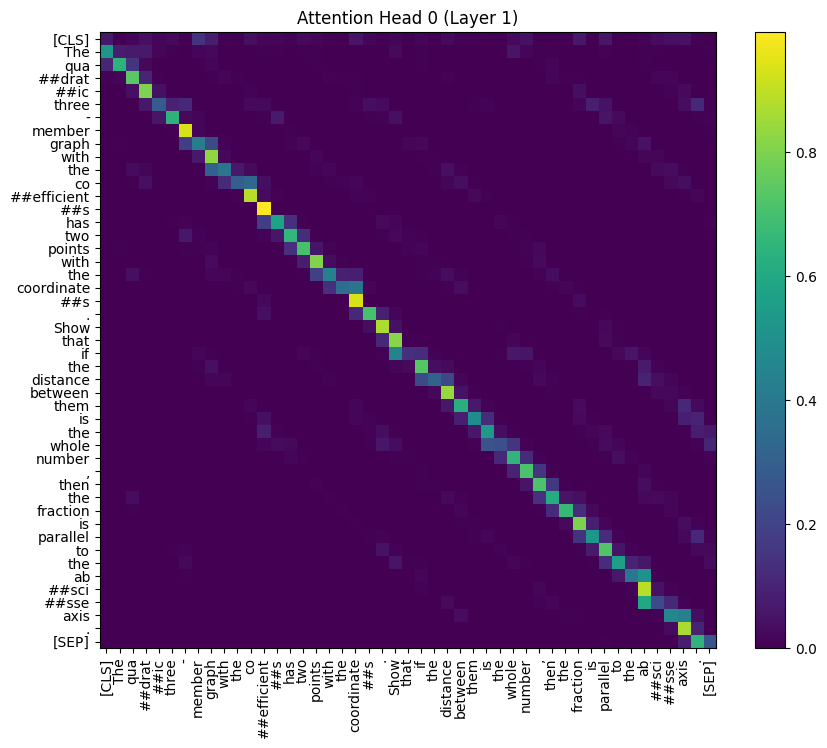

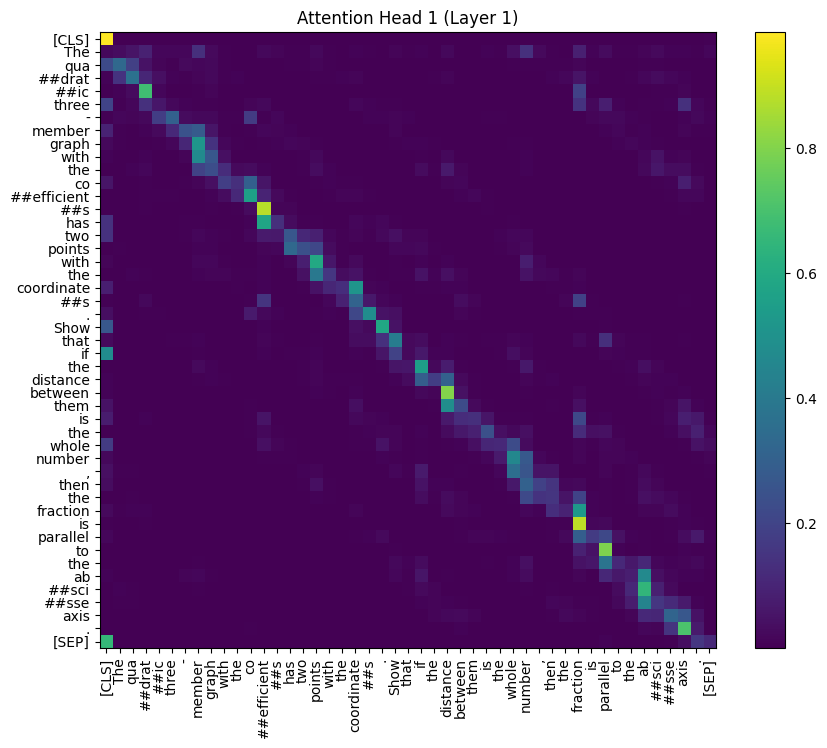

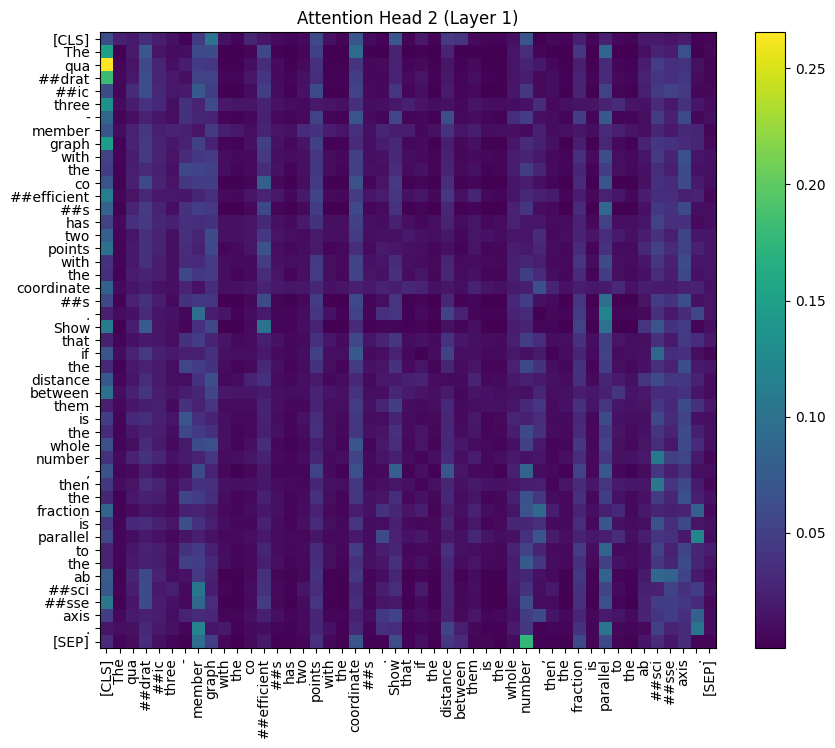

Предсказание: класс 3 (graphs), вероятность: 0.160

 МОДЕЛЬ: MathBert (необученный)

 Текст 1: To prove that the sum of the numbers of the exact square cannot be equal to 5....
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


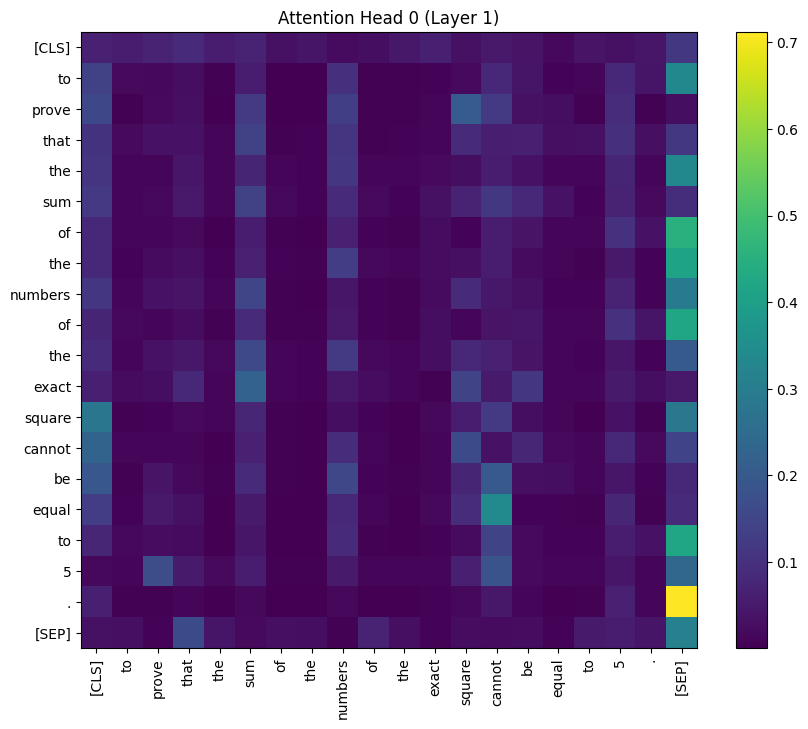

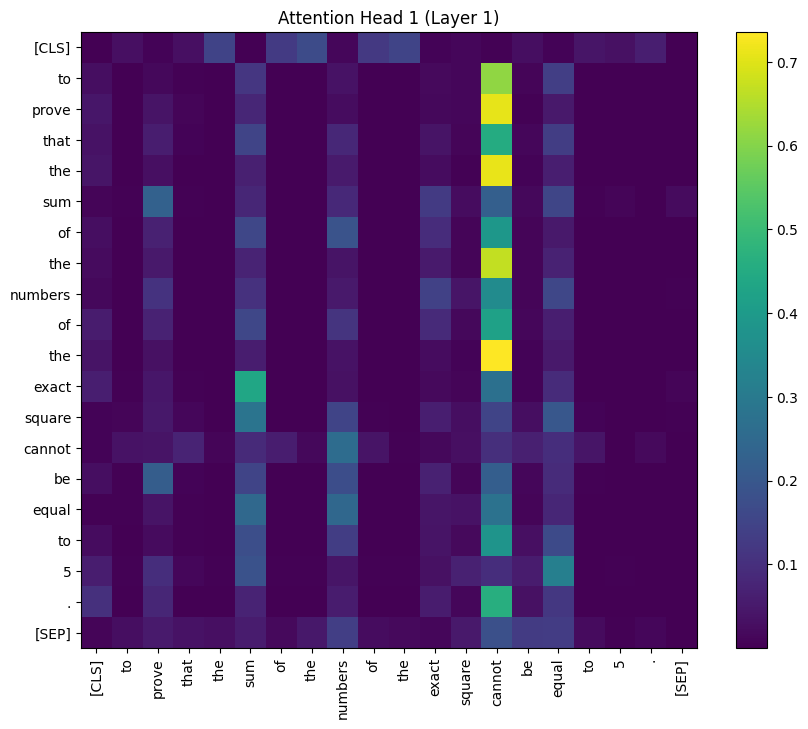

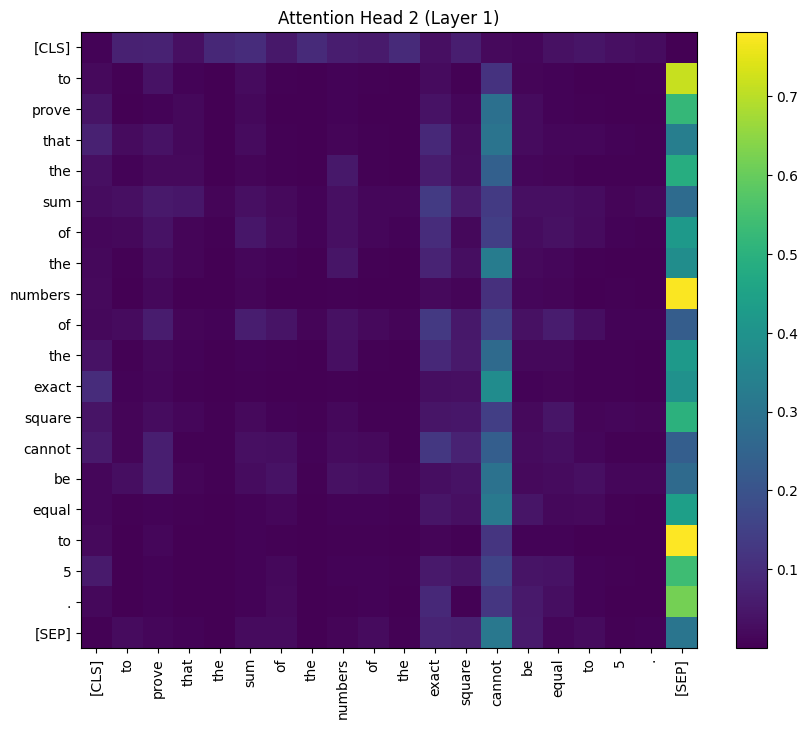

Предсказание: класс 1 (dirichlet), вероятность: 0.205

 Текст 2: ( b) Will the statement of the previous challenge remain true if Petia and Wasa ...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


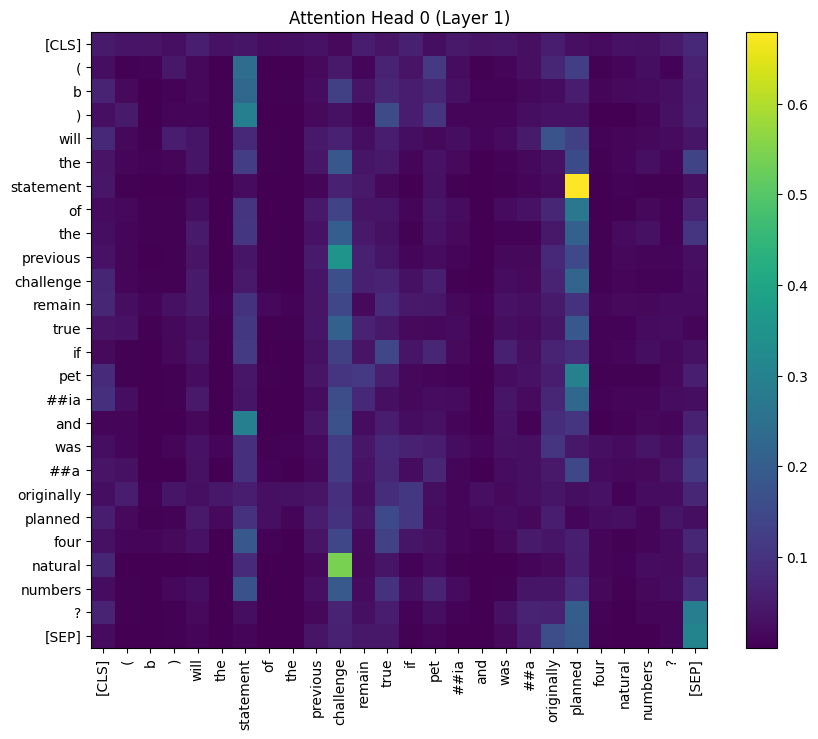

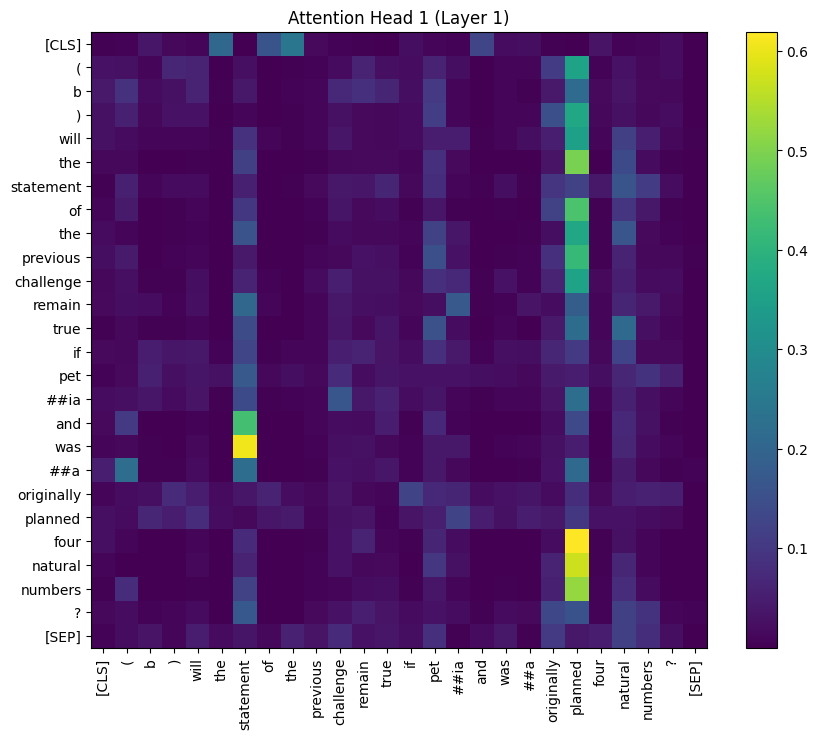

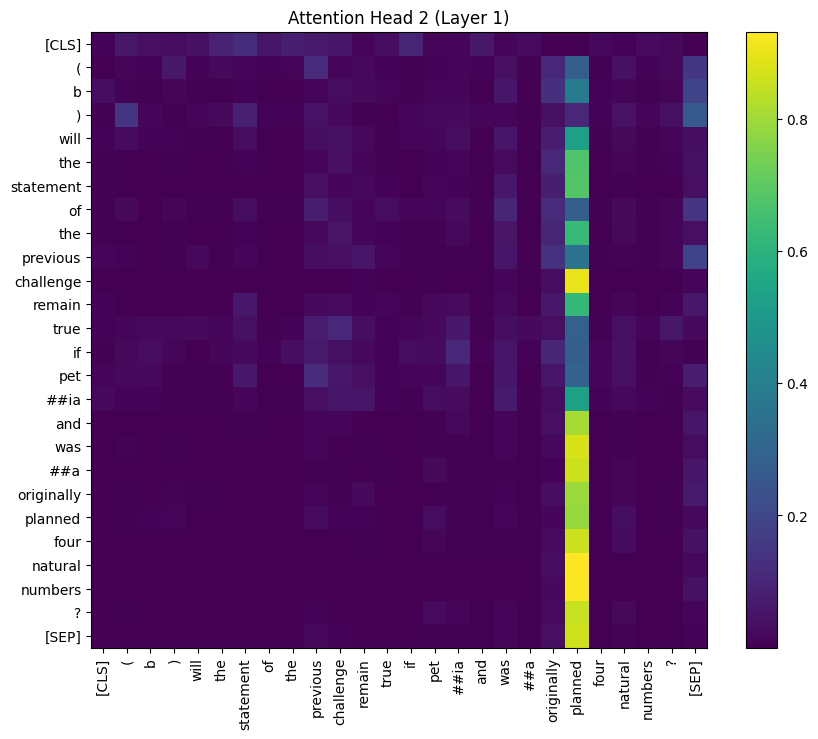

Предсказание: класс 1 (dirichlet), вероятность: 0.244

 Текст 3: The quadratic three-member graph with the coefficients has two points with the c...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


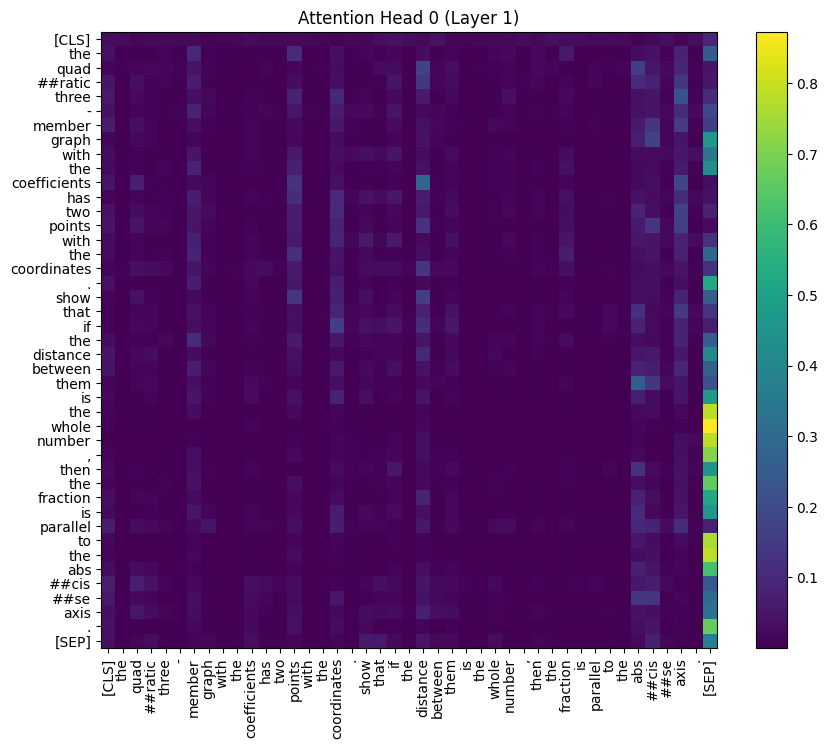

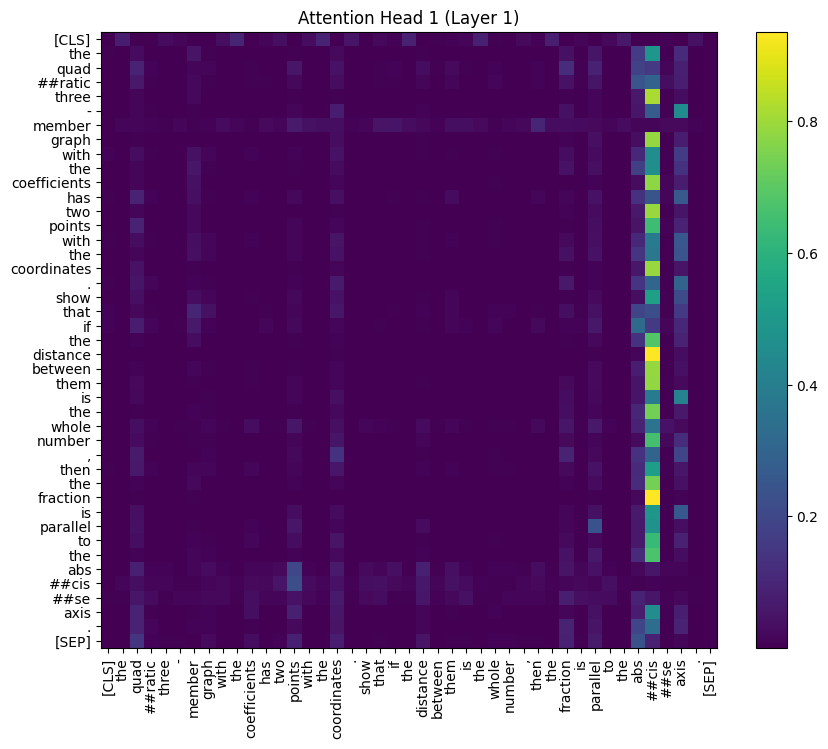

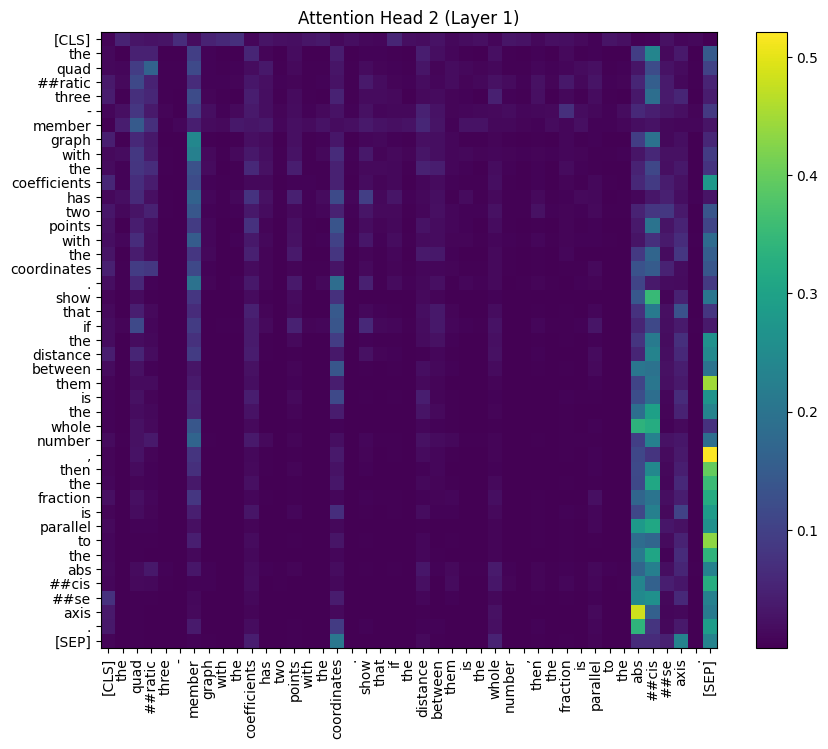

Предсказание: класс 1 (dirichlet), вероятность: 0.201

 СРАВНЕНИЕ ОДИНАКОВЫХ HEAD'ОВ В РАЗНЫХ МОДЕЛЯХ

 Текст для сравнения: To prove that the sum of the numbers of the exact square cannot be equal to 5.

 HEAD 0:

RuBert-Tiny (необученный):


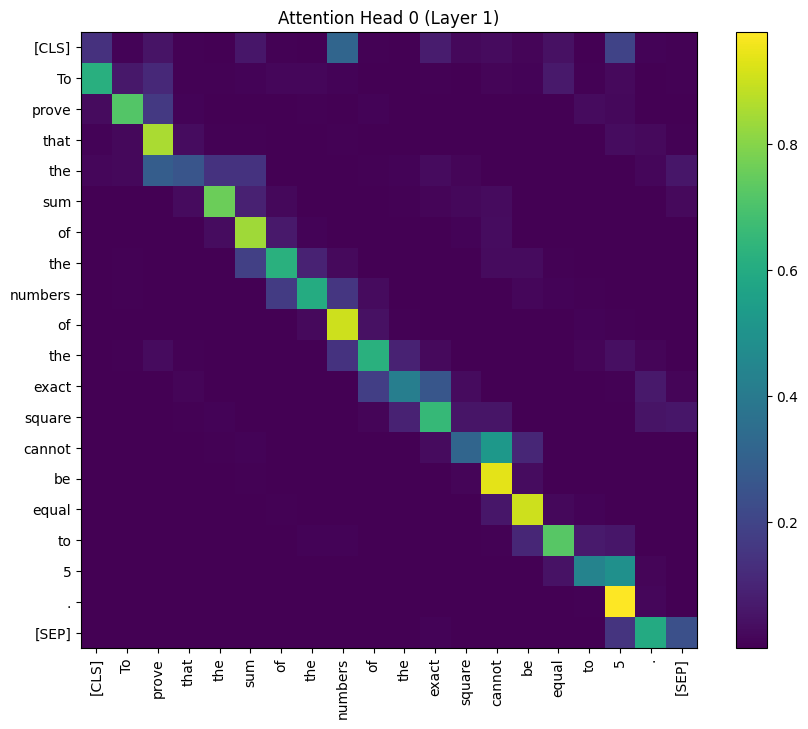


MathBert (необученный):


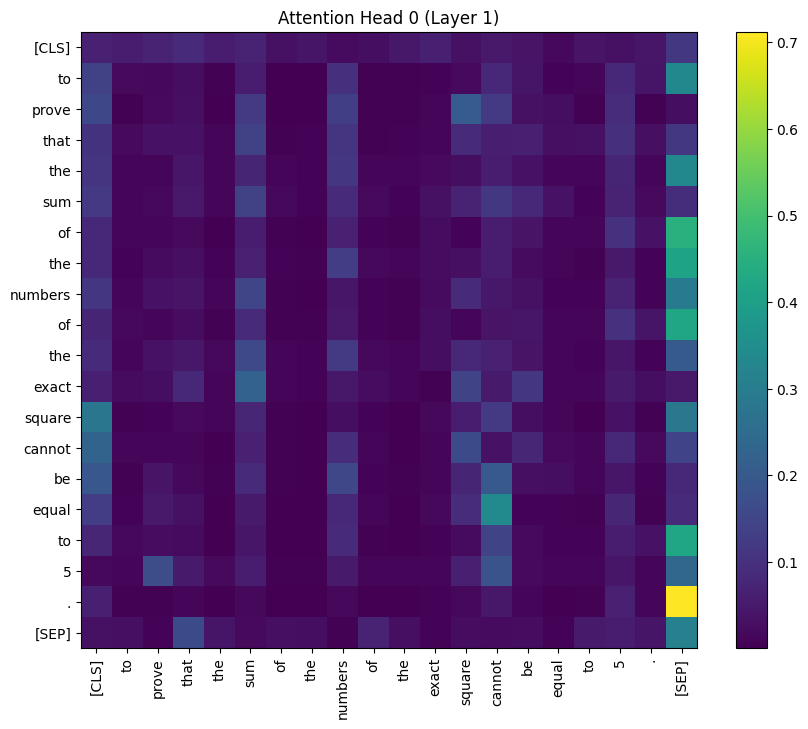


 HEAD 1:

RuBert-Tiny (необученный):


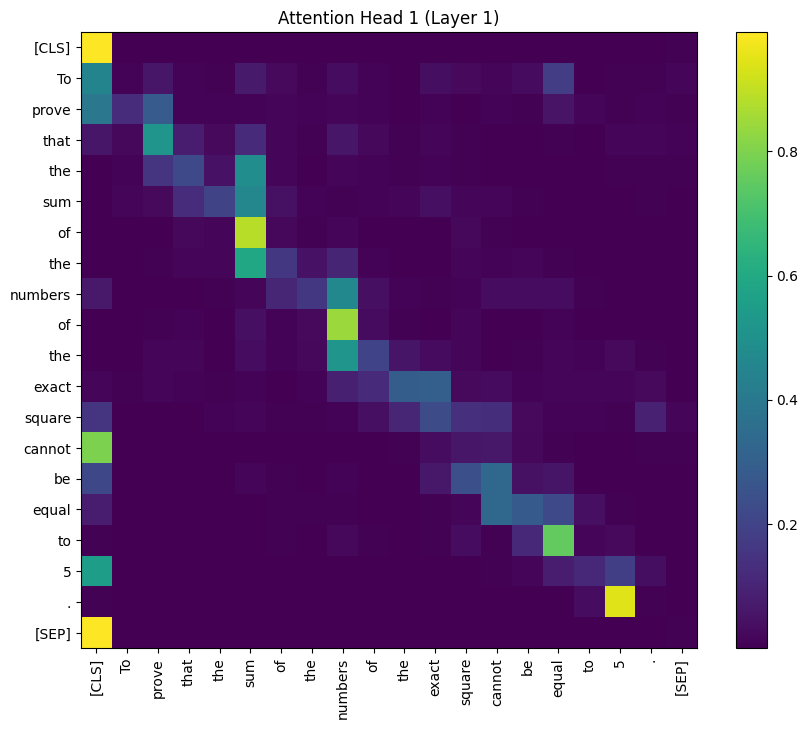


MathBert (необученный):


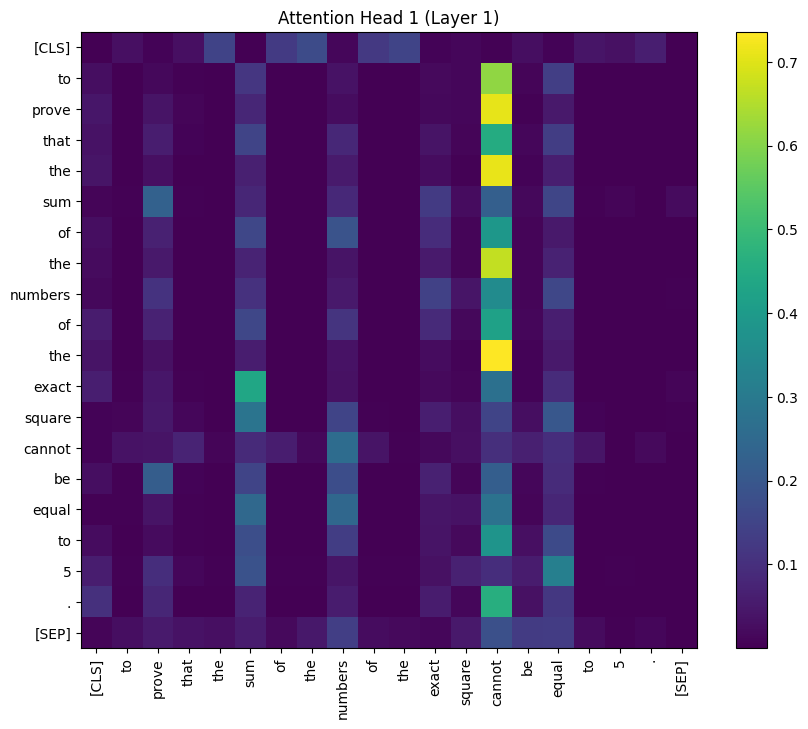


 HEAD 2:

RuBert-Tiny (необученный):


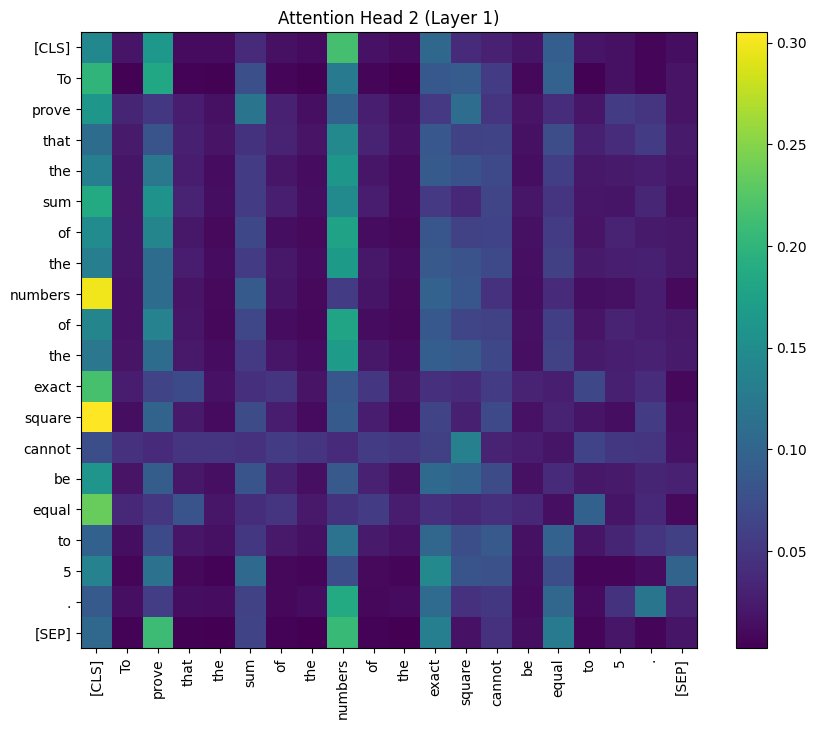


MathBert (необученный):


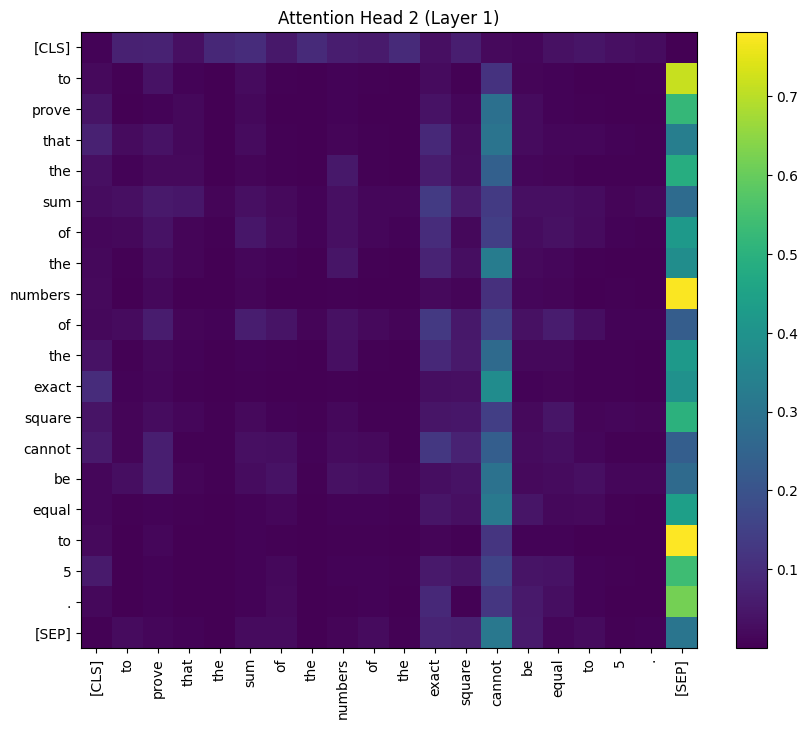

In [75]:
analyze_models_attention(models_to_analyze_before, example_texts, heads_to_visualize=3, id_to_topic=id_to_topic)

Можно заметить, что есть связь между словами типа the, that, this и т. п. Также связаны предлоги и соответствующие им слова. Лучше заметно интерпретируема связь в первой голове. Вопросительный знак препинания в конце предложения связан с вопросительными словами в начале предложений. Яркая связь существительных и местоимений, характеризующих один объект.


### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

In [76]:
models_to_analyze_after = {
    "RuBert-Tiny (дообученный)": (rubert_tiny_transformer_model_2, tokenizer),
    "MathBert (дообученный)": (mathbert_model_2, mathbert_tokenizer)
}


 МОДЕЛЬ: RuBert-Tiny (дообученный)

 Текст 1: To prove that the sum of the numbers of the exact square cannot be equal to 5....
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


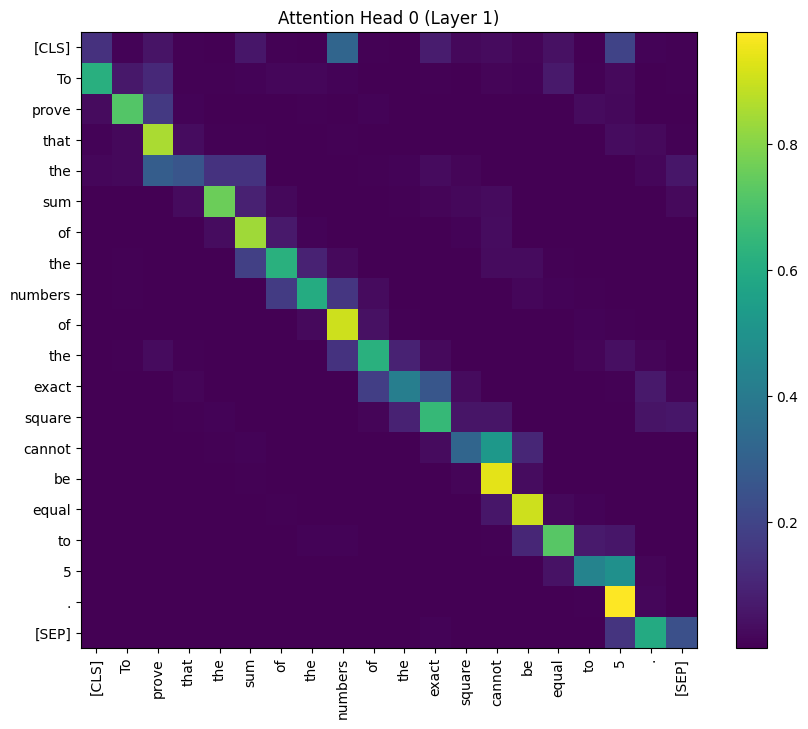

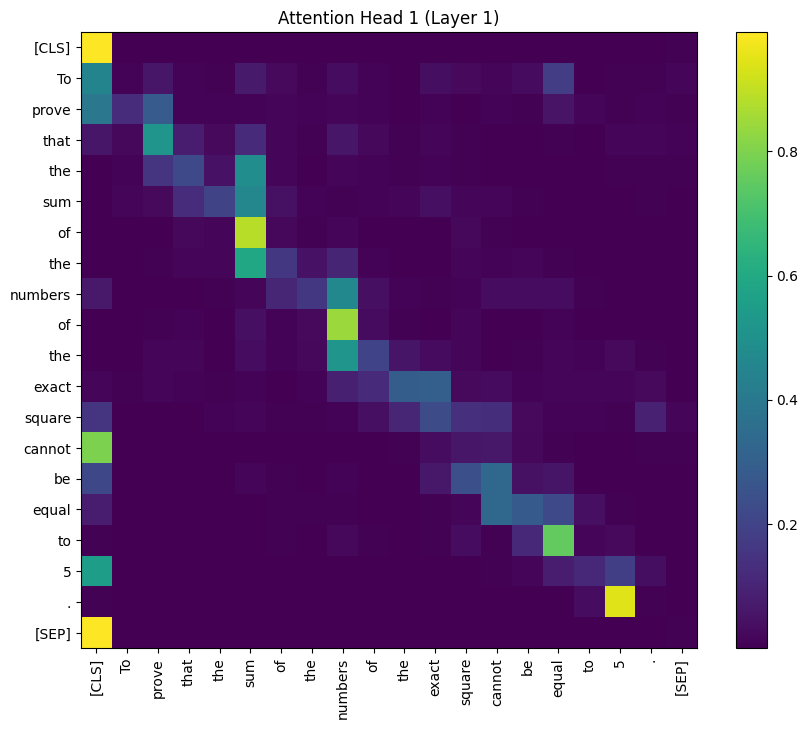

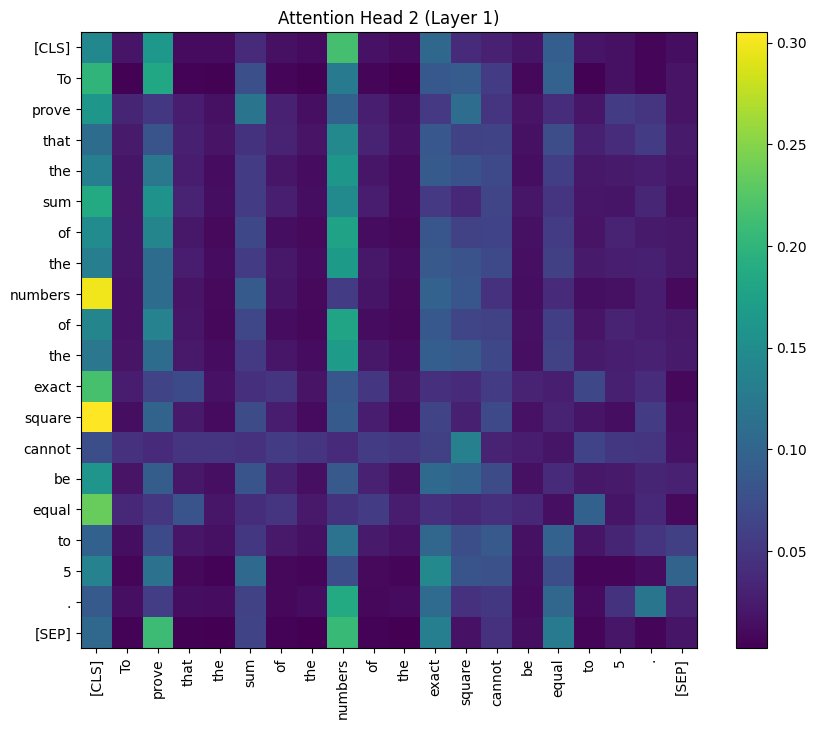

Предсказание: класс 3 (graphs), вероятность: 0.157

 Текст 2: ( b) Will the statement of the previous challenge remain true if Petia and Wasa ...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


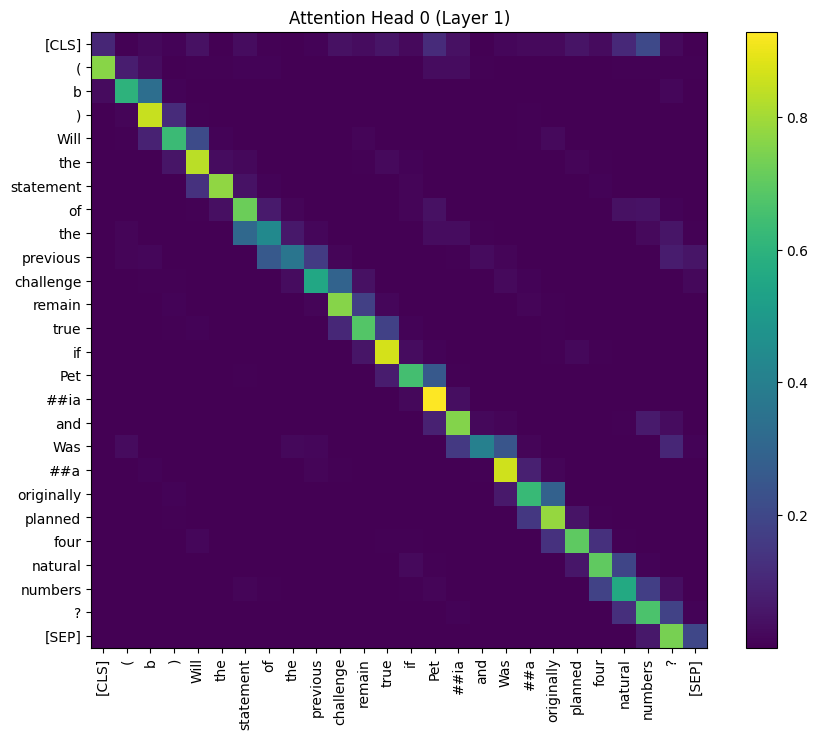

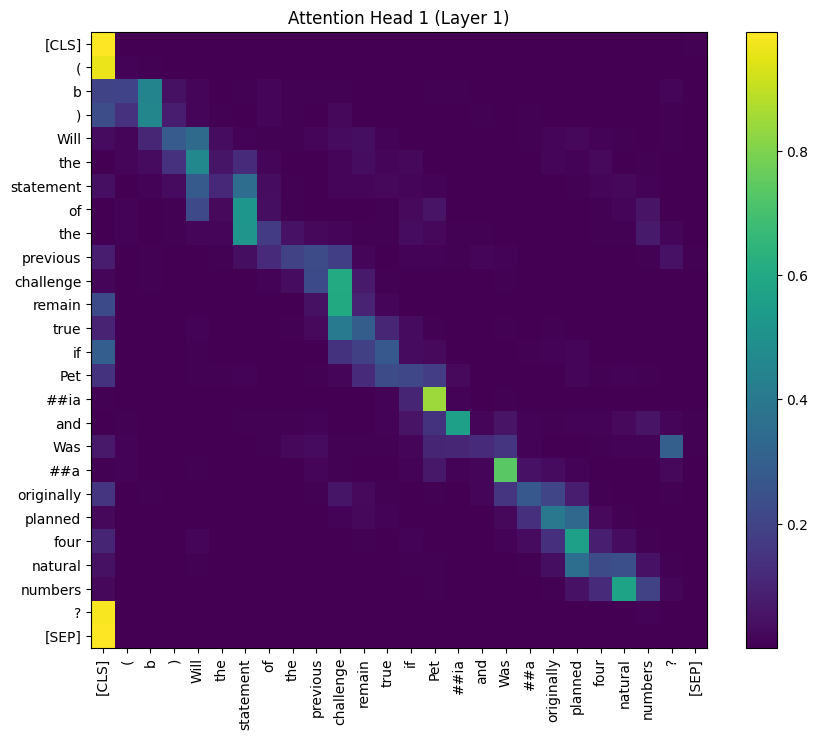

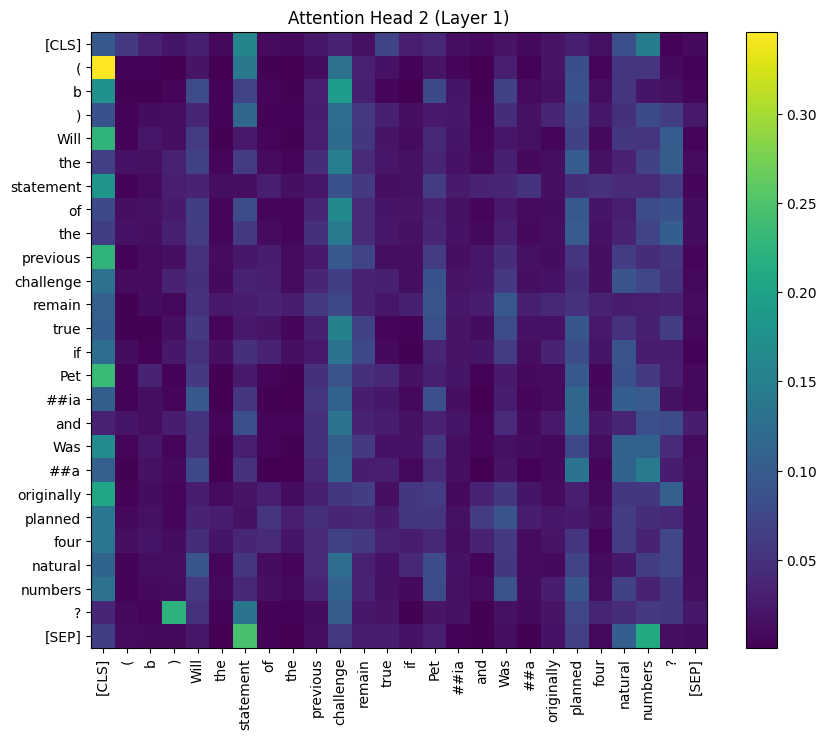

Предсказание: класс 3 (graphs), вероятность: 0.165

 Текст 3: The quadratic three-member graph with the coefficients has two points with the c...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


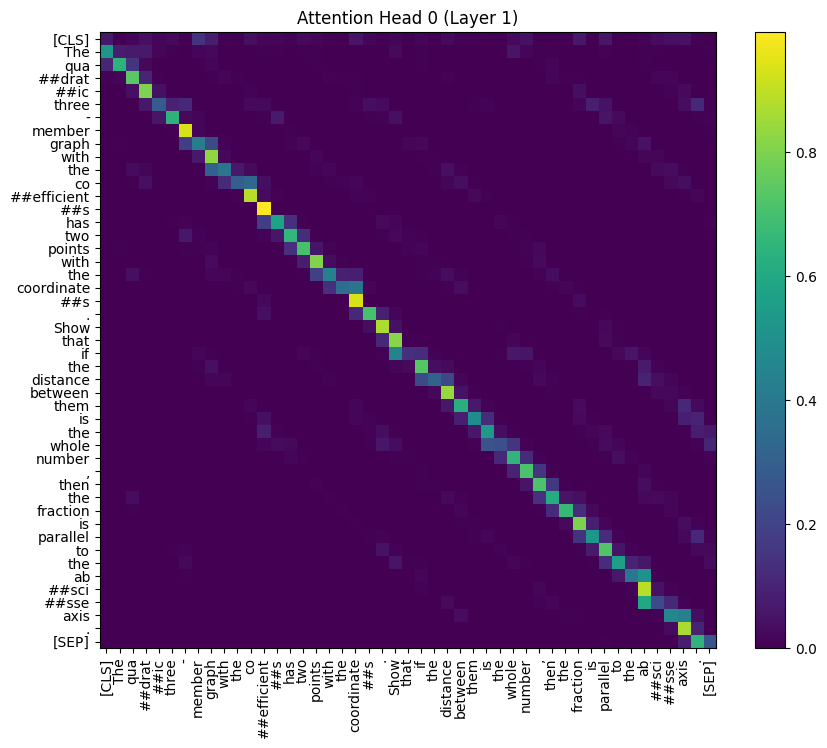

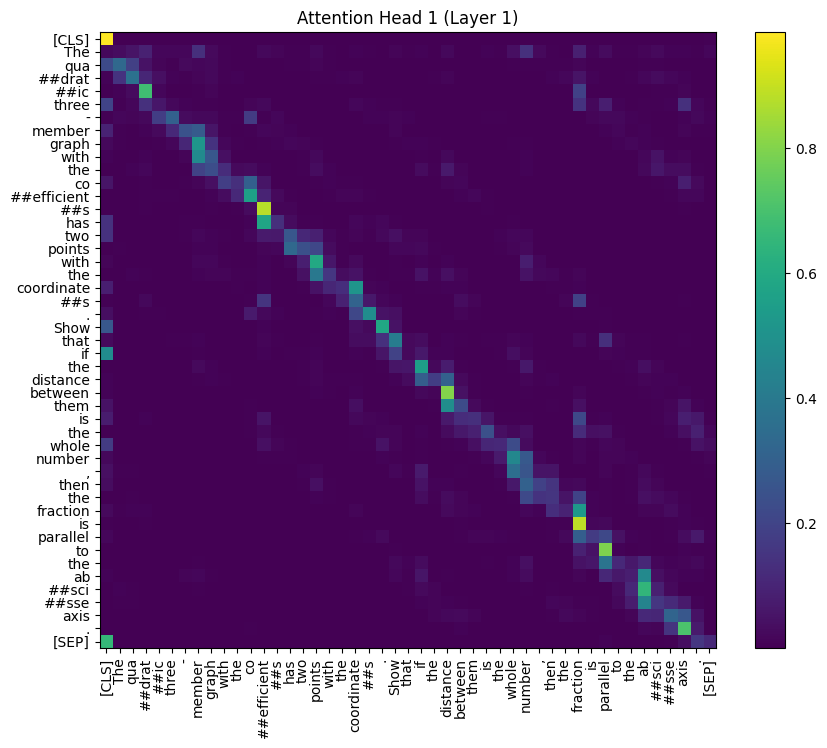

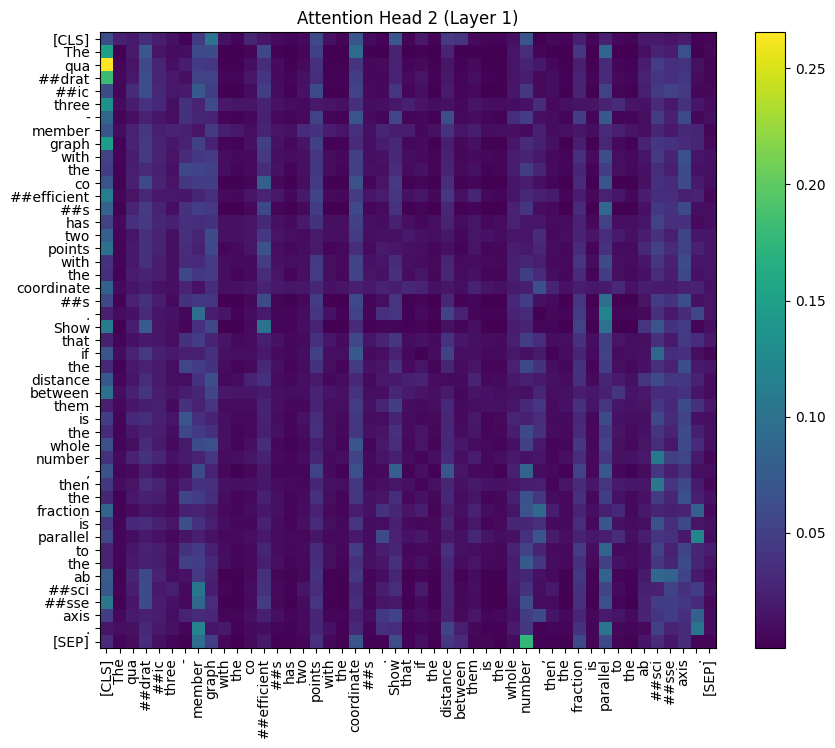

Предсказание: класс 3 (graphs), вероятность: 0.160

 МОДЕЛЬ: MathBert (дообученный)

 Текст 1: To prove that the sum of the numbers of the exact square cannot be equal to 5....
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


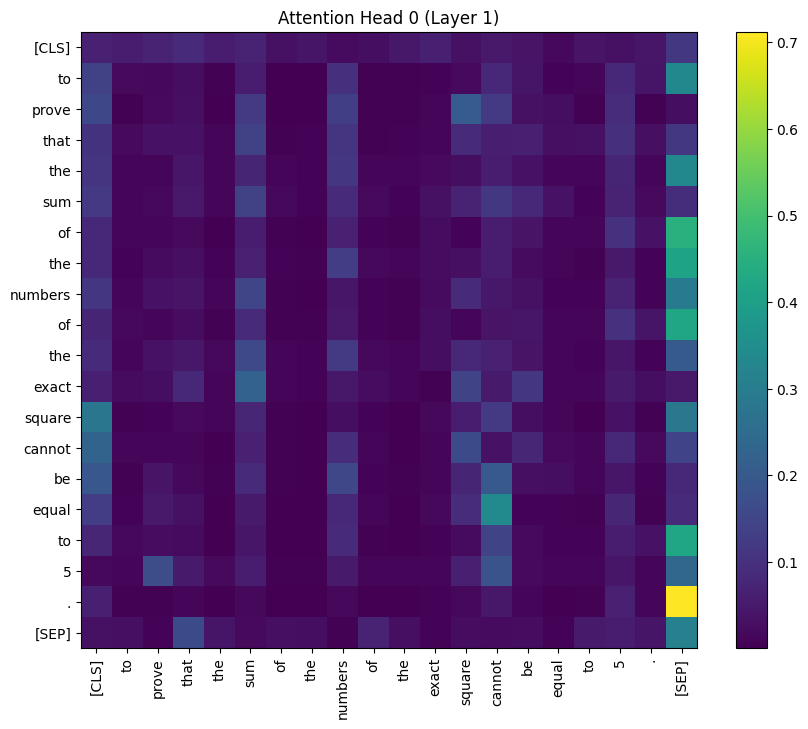

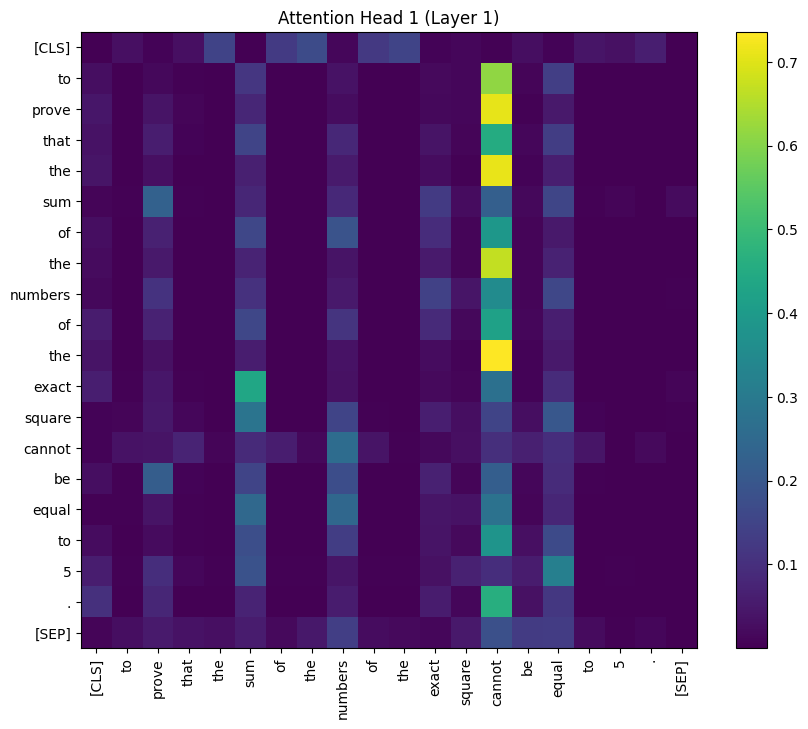

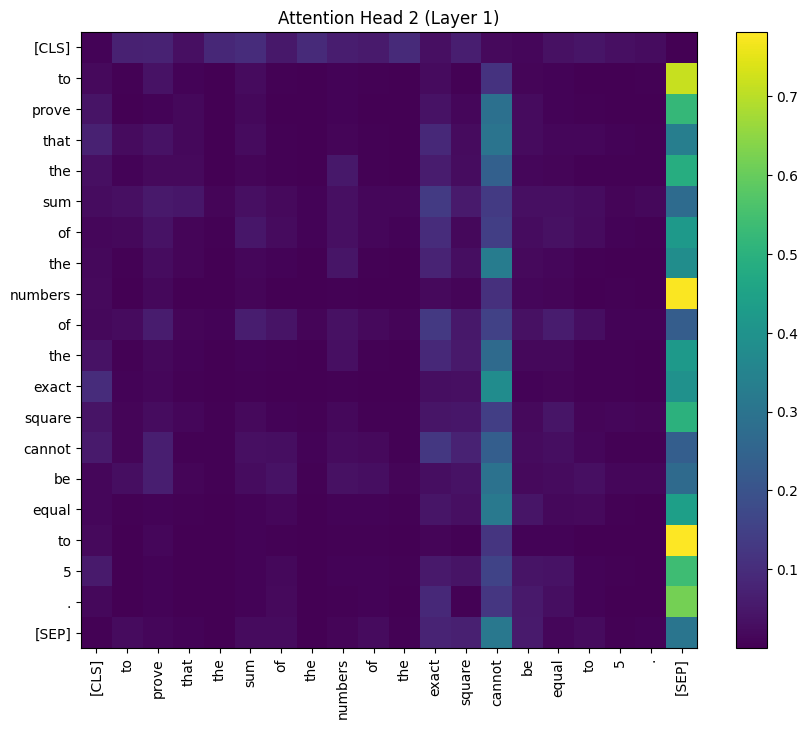

Предсказание: класс 4 (invariant), вероятность: 0.213

 Текст 2: ( b) Will the statement of the previous challenge remain true if Petia and Wasa ...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


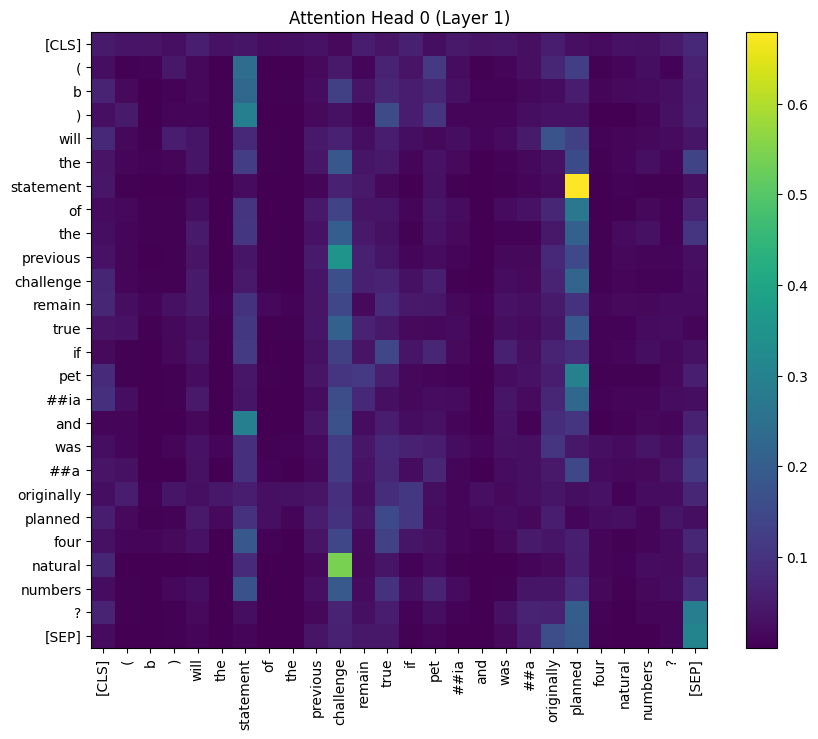

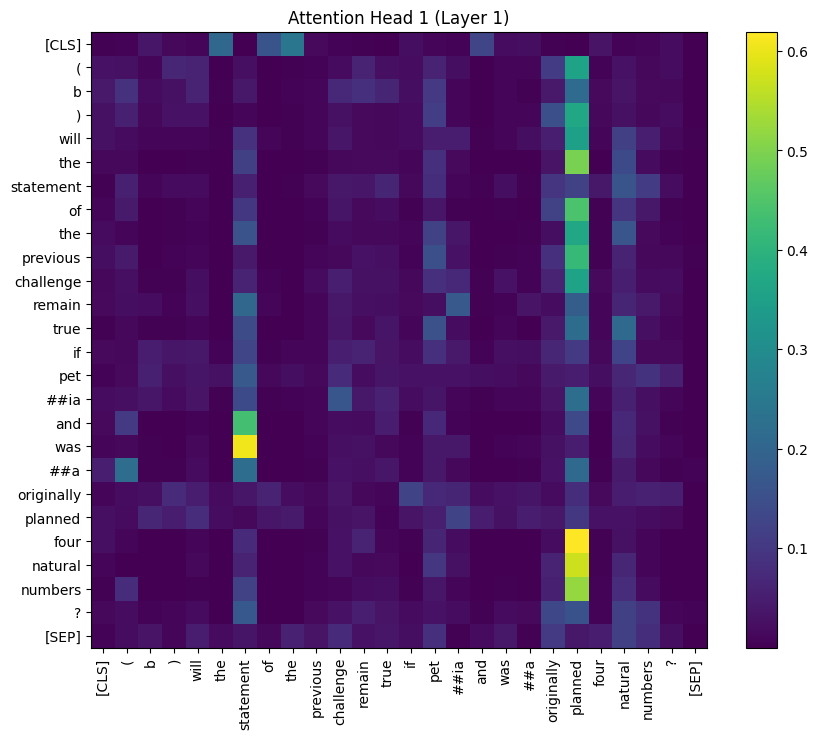

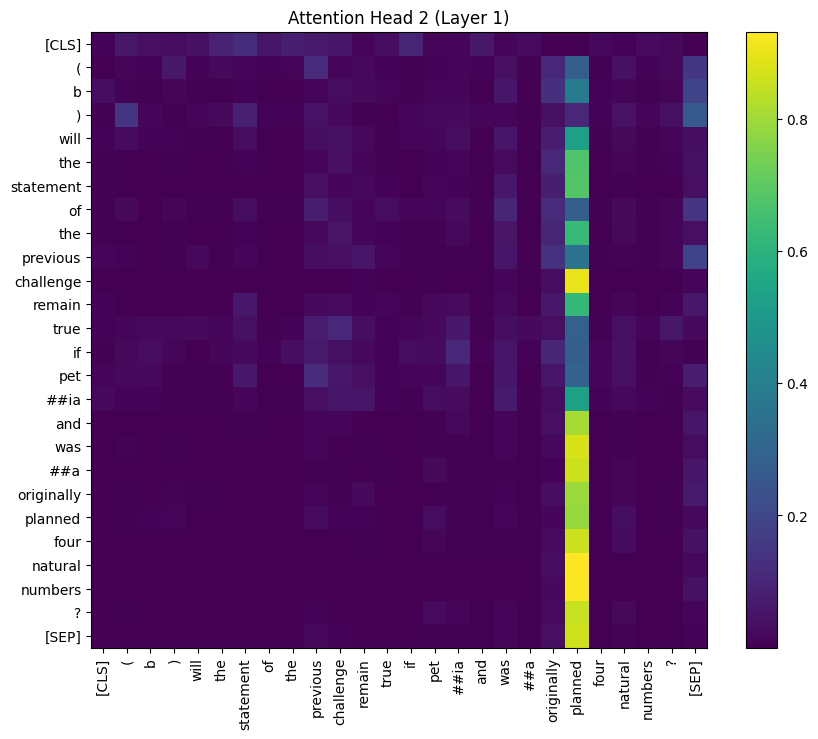

Предсказание: класс 5 (number_theory), вероятность: 0.225

 Текст 3: The quadratic three-member graph with the coefficients has two points with the c...
Количество голов внимания: 12, визуализируем головы: [0, 1, 2]


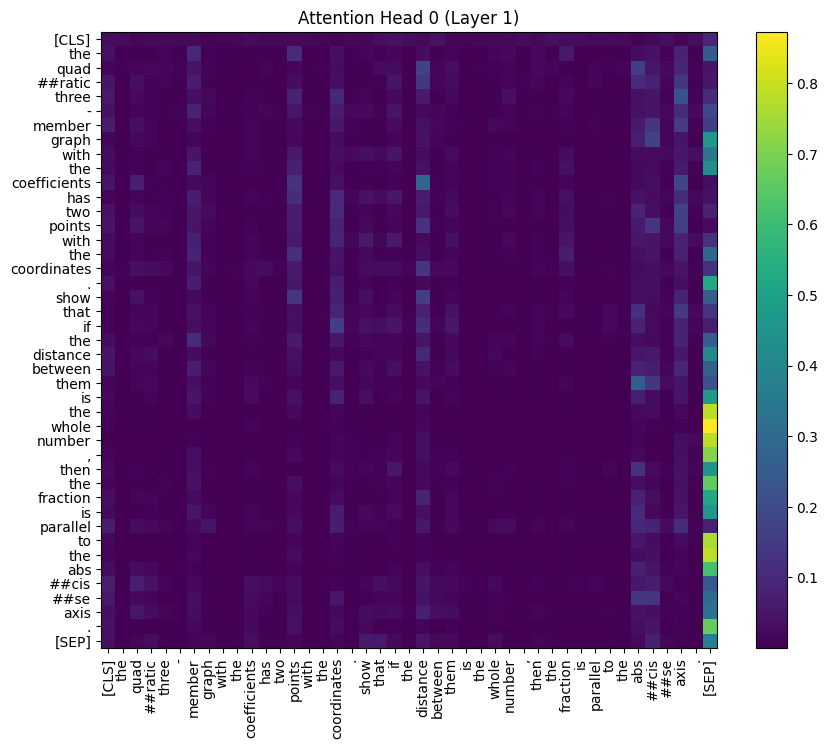

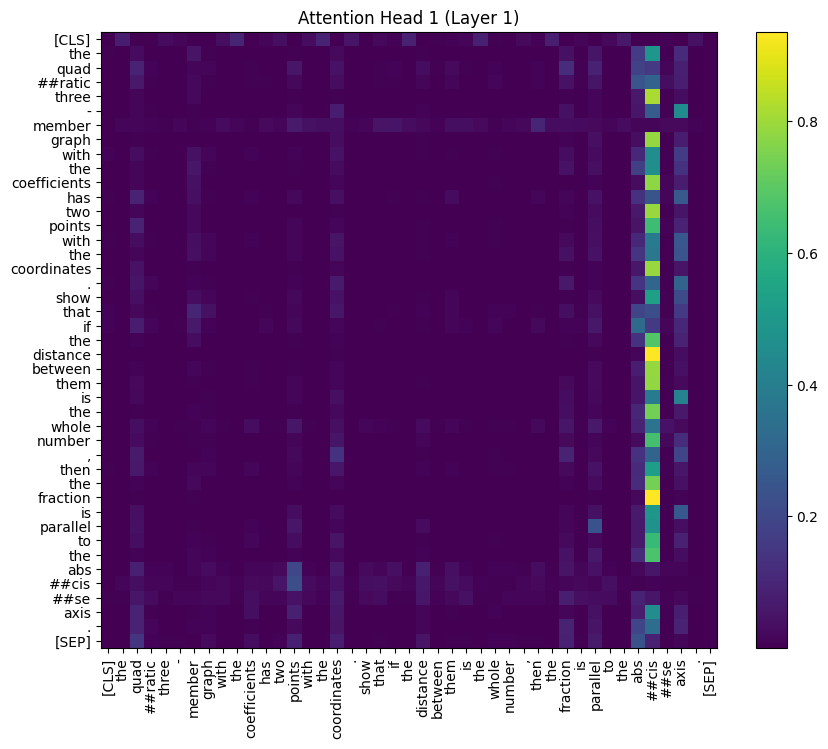

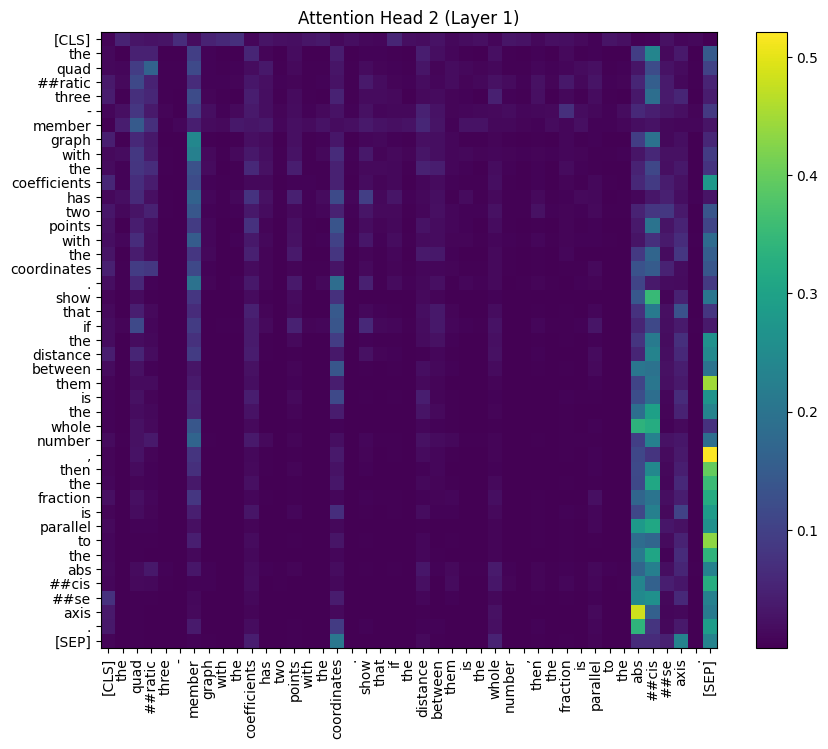

Предсказание: класс 5 (number_theory), вероятность: 0.200

 СРАВНЕНИЕ ОДИНАКОВЫХ HEAD'ОВ В РАЗНЫХ МОДЕЛЯХ

 Текст для сравнения: To prove that the sum of the numbers of the exact square cannot be equal to 5.

 HEAD 0:

RuBert-Tiny (дообученный):


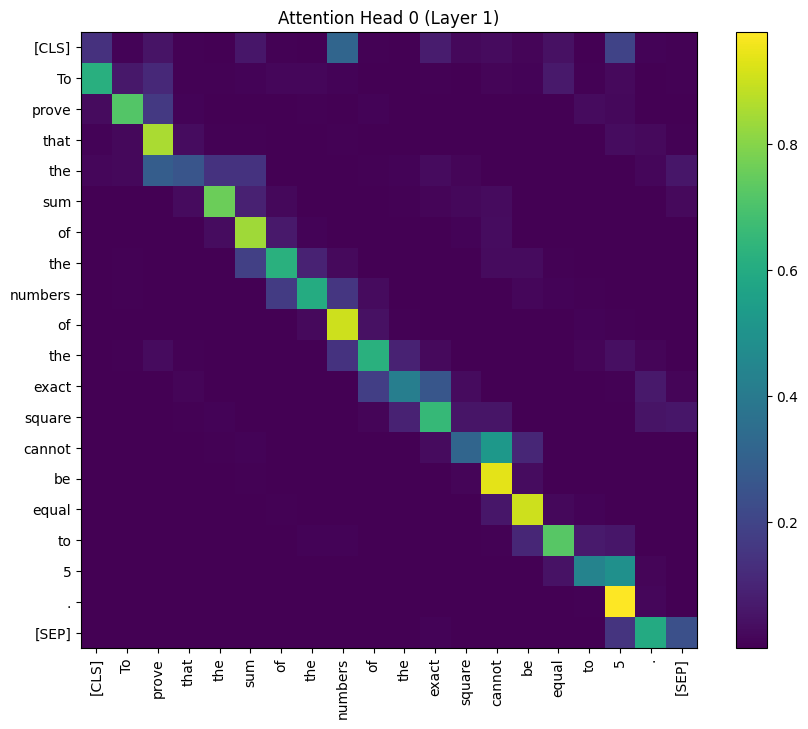


MathBert (дообученный):


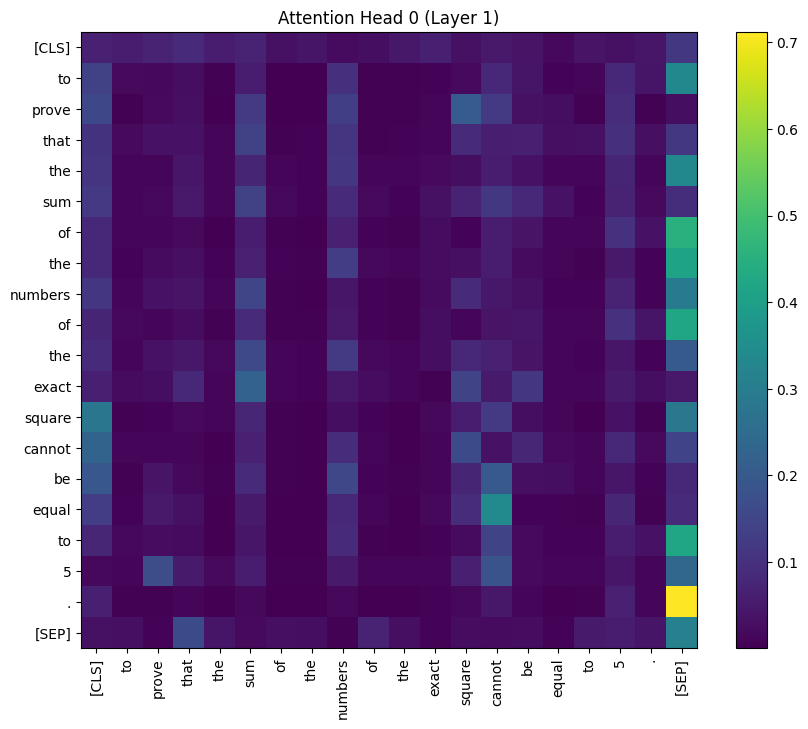


 HEAD 1:

RuBert-Tiny (дообученный):


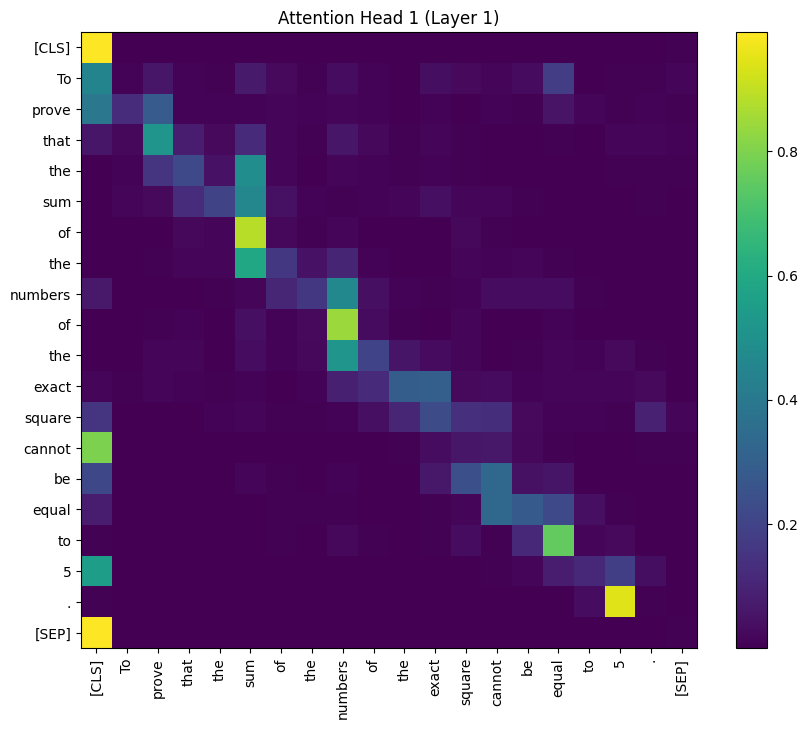


MathBert (дообученный):


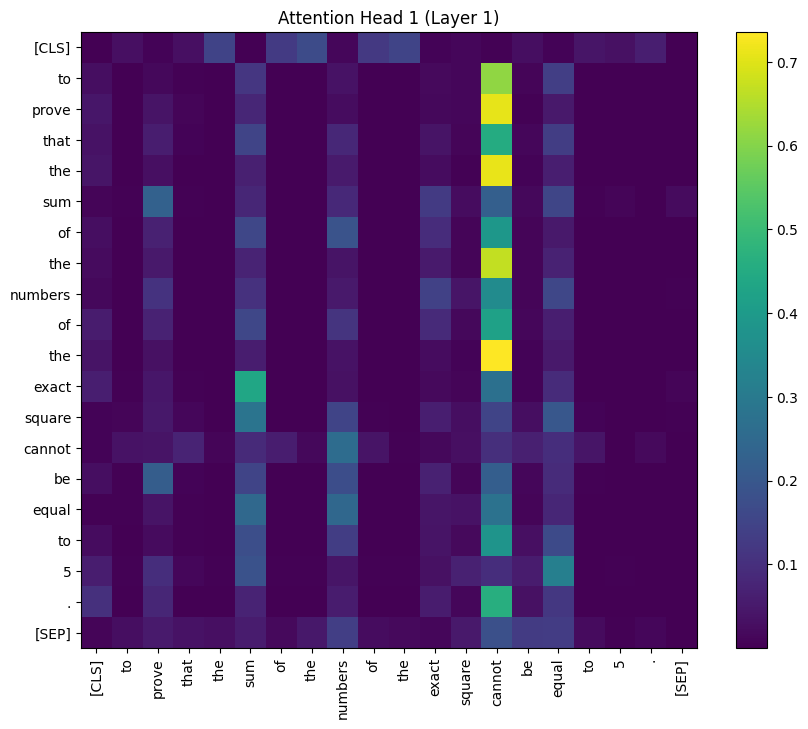


 HEAD 2:

RuBert-Tiny (дообученный):


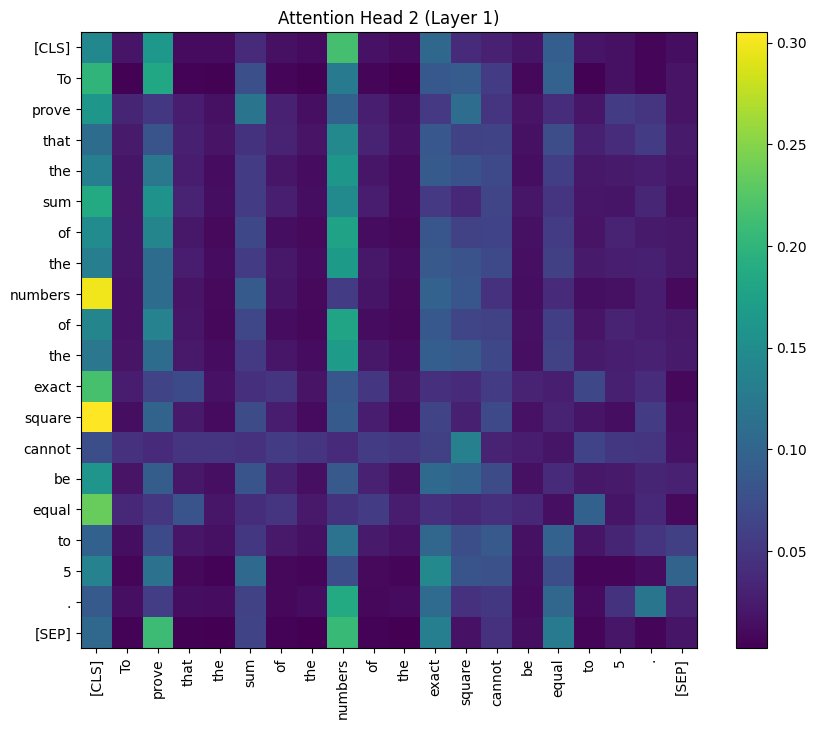


MathBert (дообученный):


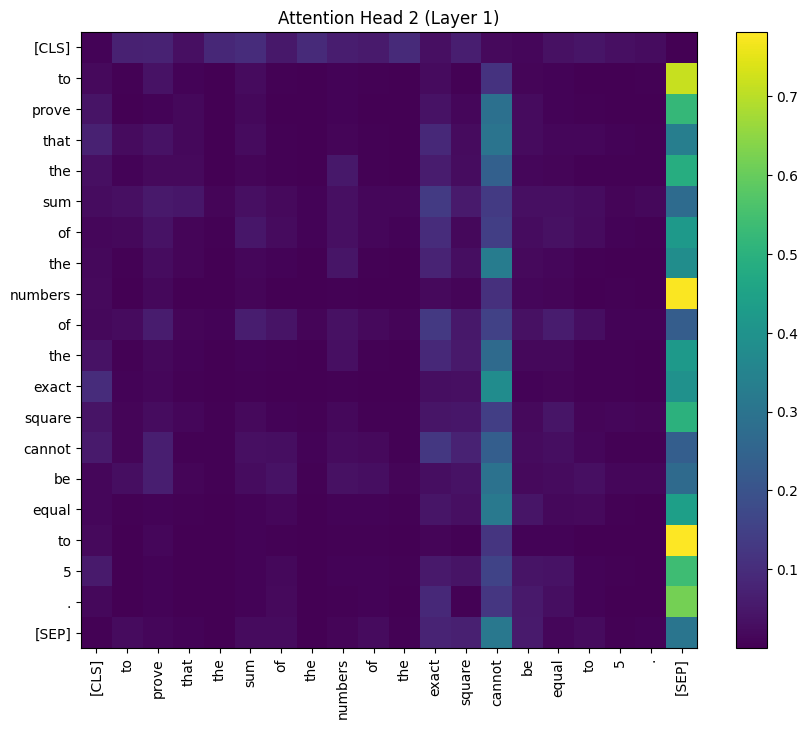

In [77]:
analyze_models_attention(models_to_analyze_after, example_texts, heads_to_visualize=3, id_to_topic=id_to_topic)

Заметим, что карты внимания не сильно изменились, т. к. fine-tuning на маленьком датасете не сильно меняет фундаментальные паттерны между словами и предложениями. Также возможно изменение происходит в более глубоких слоях, улавливающих более сложные закономерности.